## 1.1.3  Epidemic simulation with vaccination

## 1.2 Simulate a pandemic without vaccination

In [18]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar

sns.set()

# Parameters
n = 500
k = 6
beta = 0.25
rho = 0.6
week_to_simulate = 15
n_simulations = 100
initial_infected_nodes = np.random.choice(range(n), 10)


# Function to generate a preferential attachment graph
def preferential_attachment_graph(n, k):
    assert n > k + 1, "Number of nodes (n) must be greater than k + 1."

    # Initial complete graph with k + 1 nodes
    G = nx.complete_graph(k + 1)

    # At every time t>=2 create a new graph by adding a new node
    for t in range(k + 2, n):
        G.add_node( t-1) #t-1 to prevent a jump in node name enumeration n={4,5,6,___,8,9}

        # Calculate the degree of each existing node, serve as wi(t-1)
        degrees = dict(G.degree())

        # Select nodes to connect based on preferential attachment
        targets = set()

        # Loop to ensure no redundant edges to the same target
        while len(targets) < k:
            # Probability of connecting to an existing node is proportional to its current degree wi(t-1)
            chosen = random.choices(
                population=list(degrees.keys()),
                weights=list(degrees.values()),
                k=1
            )[0]
            targets.add(chosen)

        # Add edges between the new node and selected targets
        for target in targets:
            G.add_edge(t, target)

    return G



def get_infected_neighbors(G, i):
    """
    Function to get infected  and not vaccinated neighbors of a node
    """
    return list(filter(lambda neighbor: G.nodes[neighbor]['state'] == 'I' and G.nodes[neighbor]['vaccinated'] == 0, G.neighbors(i)))

def sample_individuals(size):
    numbers = list(range(500))
    random.shuffle(numbers) #random shuffle the list

    while numbers:  # while theres available numbers
        yield numbers[:size]  # return a sample
        del numbers[:size]  # delete the sampled numbers

def vaccinate_individuals(G, k):
    """
    Function to set a node as vaccinated
    """

    sampled_nodes = sample_individuals(k)
    for node in sampled_nodes:
        G.nodes[node]['vaccinated'] = 1



# Function to calculate infection/recovery probability
def P(G, i, beta=None, rho=None):
    infected_neighbors = get_infected_neighbors(G, i)
    if beta is not None:
        return 1 - (1 - beta) ** len(infected_neighbors)  # Infection probability
    elif rho is not None:
        return rho  # Recovery probability
    return 0

def EpidemicSimulation(G, beta, rho, time_limit):
    states = ['S', 'I', 'R']
    # We do not want to modify the original graph
    G = G.copy()

    # nodes_infected saves is a matrix of G.number_of_nodes() X time_limit
    # each row is associated to a node and each column to the state of the node
    #nodes_infected = np.zeros((G.number_of_nodes(), 1))

    nodes_infected = np.reshape([states.index(G.nodes[i]['state']) for i in G.nodes], (-1, 1))


    # New infected
    new_nodes_infected = [nodes_infected.sum()]

    # Warning: G.nodes[i]['state'] saves the current state, not historical data
    for t in range(1, time_limit + 1):
        # We will be modifying the states of G, so we need a copy of the iteration t - 1
        G_copy = G.copy()
        current_nodes_infected = np.copy(nodes_infected[:, -1])
        new_nodes_infected.append(0)

        # Let's make some transitions depending on the probabilities
        for i in G_copy.nodes:
            new_state = G_copy.nodes[i]['state']
            if new_state == 'S':
                # 1 if i get infected, 0 otherwise
                i_is_infected = np.random.binomial(1, P(G_copy, i, beta = beta))

                if i_is_infected:
                    new_state = 'I'
                    new_nodes_infected[-1] += 1

            elif new_state == 'I':
                # 1 if i get recovered, 0 otherwise
                i_is_recovered = np.random.binomial(1, P(G_copy, i, rho = rho))

                if i_is_recovered:
                    new_state = 'R'

            # Let's update the state of the node
            G.nodes[i]['state'] = new_state
            current_nodes_infected[i] = states.index(new_state)

        nodes_infected = np.append(nodes_infected, current_nodes_infected.reshape(-1, 1), axis=1)

    return nodes_infected, new_nodes_infected



# Function for running multiple simulations
def Simulations(G, beta, rho, time_limit = 15, n_simulations = 100, use_progressbar=True):
    simulations = []
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)

    for s in range(n_simulations):
        simulations.append(EpidemicSimulation(G, beta, rho, time_limit))
        if use_progressbar:
            bar.update(s+1)

    if use_progressbar:
        bar.finish()

    return simulations




In [24]:
G.nodes

NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [31]:
G.nodes[0]['vaccinated']

0

In [34]:
 vaccinate_individuals(G, 5)

TypeError: unhashable type: 'list'

In [33]:
list(filter(lambda x: G.nodes[x]['vaccinated'] == 1 , G.nodes))

[]

In [27]:
# Generate graph
G = preferential_attachment_graph(n, k)


# Set initial state for nodes
for node in initial_infected_nodes:
    G.nodes[node]['state'] = 'I'
    G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated

for node in G.nodes():
    if node not in initial_infected_nodes:
        G.nodes[node]['state'] = 'S'  # Default state for non-infected nodes
    G.nodes[node]['vaccinated'] = 0 #At week 0 nobody is vaccinated

# Run simulations
S = Simulations(G, beta, rho, time_limit = week_to_simulate, n_simulations=n_simulations)

# Calculate the average number of new infected nodes
average_new_nodes_infected = np.mean([simulation[1] for simulation in S], axis=0)



100% (100 of 100) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


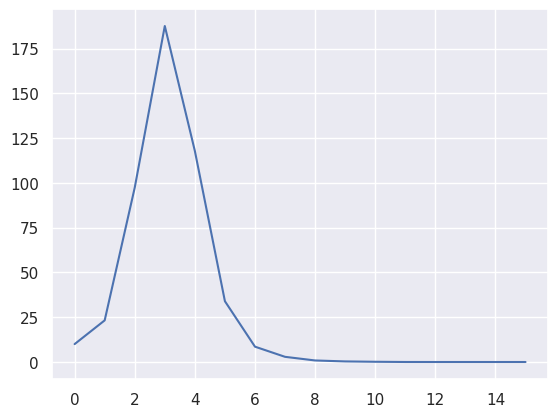

In [4]:

plt.plot(average_new_nodes_infected)

[[4.9000e+02 4.5340e+02 3.1628e+02 1.3222e+02 4.8830e+01 2.6740e+01
  2.0970e+01 1.9180e+01 1.8670e+01 1.8410e+01 1.8280e+01 1.8220e+01
  1.8200e+01 1.8190e+01 1.8190e+01 1.8190e+01]
 [1.0000e+01 4.0740e+01 1.5362e+02 2.4656e+02 1.8161e+02 9.4010e+01
  4.3030e+01 1.8900e+01 7.8100e+00 3.3300e+00 1.5400e+00 5.7000e-01
  2.3000e-01 1.0000e-01 1.0000e-02 0.0000e+00]
 [0.0000e+00 5.8600e+00 3.0100e+01 1.2122e+02 2.6956e+02 3.7925e+02
  4.3600e+02 4.6192e+02 4.7352e+02 4.7826e+02 4.8018e+02 4.8121e+02
  4.8157e+02 4.8171e+02 4.8180e+02 4.8181e+02]]


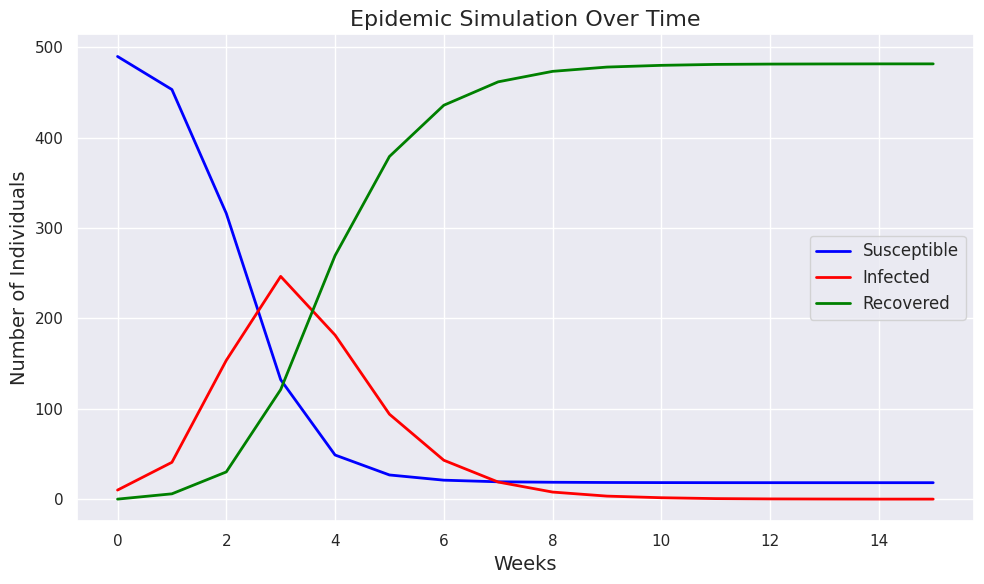

In [ ]:
# Extract and calculate the total number of S, I, and R nodes for each week
def calculate_average_states(simulations):
    time_limit = len(simulations[0][1])
    total_states = np.zeros((3, time_limit))  # For S, I, R
    for simulation in simulations: # Simulation has a tuple of matrix with 500 rows and 15 columns and a vector with the new infected
        states = simulation[0]  # Get the state history for each node
        for t in range(states.shape[1]): # states.shape[1] returns the number of weeks of the simulation
            # summing the number of S,I,R by each week
            total_states[0, t] += np.sum(states[:, t] == 0)  # Susceptible (S)
            total_states[1, t] += np.sum(states[:, t] == 1)  # Infected (I)
            total_states[2, t] += np.sum(states[:, t] == 2)  # Recovered (R)

    # Calculate the average across all simulations
    average_states = total_states / len(simulations) # we divide by the number of simulations length (simulations)
    return average_states

# Calculate the average states for S, I, R
average_states = calculate_average_states(S)
print (average_states)
# Plotting the results
time = range(week_to_simulate + 1)
plt.figure(figsize=(10, 6))

plt.plot(time, average_states[0], label='Susceptible', color='blue', linewidth=2)
plt.plot(time, average_states[1], label='Infected', color='red', linewidth=2)
plt.plot(time, average_states[2], label='Recovered', color='green', linewidth=2)

plt.title("Epidemic Simulation Over Time", fontsize=16)
plt.xlabel("Weeks", fontsize=14)
plt.ylabel("Number of Individuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()